In [5]:
%matplotlib inline 
from sets import Set
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
def parse_attributes(attributes):
    for attr in attributes:
        if "=" in attr:
            [key, val] = attr.split('=')
            yield (key, val)

def get_feature_names(df):
    row_info = df['INFO'][0].split(';')
    feature_names = Set([])
    for (key, val) in parse_attributes(row_info):
        feature_names.add(key)
    return list(feature_names)

In [7]:
def features_from_VCF(filename):
    """
    Generate a Pandas dataframe from a VCF file
    :param filename: Path to the VCF file
    :return: Pandas dataframe containing features for each record in VCF
    """

    # Ignore non-numeric columns (consider accounting for these later on)
    ignore_cols = {'DB', 'POSITIVE_TRAIN_SITE', 'culprit'}

    
    df = pd.read_csv(filename, sep='\t')
    num_rows = df.shape[0]
    feature_names = get_feature_names(df)
    feature_names.append('PASSED_VQSR')
    features = pd.DataFrame(np.zeros(shape=(num_rows, len(feature_names))), columns=feature_names)
    #row_info = df['INFO'][0]
    for index, row in df.iterrows():
        attrs = row['INFO'].split(';')
        for (key, val) in parse_attributes(attrs):
            if key in feature_names and key not in ignore_cols:
                # TODO: This is NOT the correct/robust way to handle this case. This is the case where the
                # location has multiple calls (e.g. heterozygosity for example). For now, just take the first
                # attribute for simplicity
                if ',' in val:
                    val = val.split(',')[0]
                features.set_value(index, key, val)
        
        passed_VQSR = row['FILTER']
        if passed_VQSR == 'PASS':
            features.set_value(index, 'PASSED_VQSR', 1)
        else:
            features.set_value(index, 'PASSED_VQSR', 0)
            

    return features

## Preproces VCF features and Save Output

In [8]:
features = features_from_VCF('data/VQSRfilter/NA12878.LowSeq.illumina.bwa.sorted.dedup.20.sam.wFlag.qual.raw.snps.vqsr.recal copy.vcf')
features.to_csv('data/preprocessed/vcf_features_with_VQSR_labels.txt', sep='\t')

## If Preprocessing has Already Been Performed, then read in the Data

In [9]:
features = pd.read_csv('data/preprocessed/vcf_features_with_VQSR_labels.txt', sep='\t')

### Store the features themselves and the VQSR labels separately

In [14]:
passed_vqsr = features['PASSED_VQSR']
features = features.drop(['PASSED_VQSR'], axis=1)

## Data Visualization Using T-SNE

In [15]:
def plot_embedding(embedding):
    """
    Plot a 2-dimensional embedding of a dataset
    :param embedding: The embedding
    :return: None
    """

    fig, ax = plt.subplots(figsize = (10,10))
    #for i,group in df.groupby(colorby):
    #    group.plot(x='DIM1',y='DIM2',kind='scatter',label=i,color=colors[color],title=plot_title,ax=ax)
    #    color = color + 1
    plt.plot(embedding[:,0], embedding[:,1], 'bo')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()

### T-SNE Embedding without Any Labeling

In [ ]:
num_features_to_embed = features.shape[0]
model = TSNE(n_components=2, random_state=0)
embedding = model.fit_transform(features[:num_features_to_embed])
plot_embedding(embedding)

#### It's not immediately clear if there is much structure in the VCF file annotation space

### T-SNE Embedding using VQSR Filter Output for Labels

In [29]:
vqsr_pos_indices = passed_vqsr[passed_vqsr == 1].index
vqsr_pos_indices = [i for i in vqsr_pos_indices if i < num_features_to_embed]
vqsr_neg_indices = passed_vqsr[passed_vqsr == 0].index;
vqsr_neg_indices = [i for i in vqsr_neg_indices if i < num_features_to_embed]

vqsr_pos_embedding = embedding[vqsr_pos_indices];
vqsr_neg_embedding = embedding[vqsr_neg_indices];

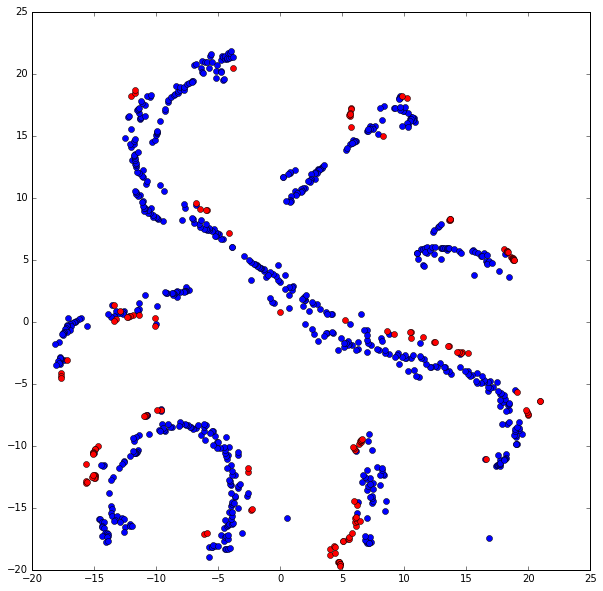

In [30]:
fig, ax = plt.subplots(figsize = (10,10))

plt.plot(vqsr_pos_embedding[:,0], vqsr_pos_embedding[:,1], 'bo')
plt.plot(vqsr_neg_embedding[:,0], vqsr_neg_embedding[:,1], 'ro')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

#### It's still not clear if VQSR is finding some structure in the VCF file's annotations. 

## Do the same as above but use Ground Truth for Labels rather than VQSR (Note: you must preprocess ground truth file before doing this)

In [ ]:
true_labels = 0;

In [32]:
features.shape[0]/10

8682